In [2]:
import sys
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats

sys.path.append('..')

from src.engineer.geowiki import GeoWikiDataInstance
from src.engineer.nigeria import NigeriaDataInstance
from src.exporters.sentinel.cloudfree import BANDS

%reload_ext autoreload
%autoreload 2

## Process geowiki data

### Put all pickle files in a dataframe

In [3]:
geowiki_path = Path('../data/features/geowiki_landcover_2017/all')
pickle_files = [file for file in geowiki_path.glob('*.pkl')]
len(pickle_files)

35599

In [4]:
crop_probability_threshold = None
rows = []
for file in pickle_files:
    identifier = file.name.split('_')[0]
    date = '_'.join(pickle_files[0].name.split('_')[1:]).split('.')[0]

    with file.open("rb") as f:
        target_datainstance = pickle.load(f)

    assert isinstance(target_datainstance, GeoWikiDataInstance), 'Pickle file is not an instance of geowiki data'
    if crop_probability_threshold is None:
        label = target_datainstance.crop_probability
    else:
        label = int(target_datainstance.crop_probability >= crop_probability_threshold)

    rows.append((identifier, date, target_datainstance.instance_lat, target_datainstance.instance_lon, target_datainstance.labelled_array, label))


In [5]:
df = pd.DataFrame(rows, columns=['identifier', 'date', 'lat', 'lon', 'data', 'label'])
df

,identifier,date,lat,lon,data,label
0,3233,2017-03-28_2018-03-28,-21.547574,138.249959,"[[0.1594, 0.1606, 0.1863, 0.267, 0.2753, 0.299...",0.000000
1,2246,2017-03-28_2018-03-28,-26.547597,148.250004,"[[0.1752, 0.1814, 0.1899, 0.2194, 0.2288, 0.26...",0.800000
2,12913,2017-03-28_2018-03-28,11.151821,-2.848243,"[[0.1686, 0.1499, 0.1446, 0.1586, 0.164, 0.186...",0.224000
3,18861,2017-03-28_2018-03-28,27.452380,56.250033,"[[0.1805, 0.1724, 0.1816, 0.2085, 0.225, 0.258...",0.000000
4,32400,2017-03-28_2018-03-28,51.250010,4.952367,"[[0.1494, 0.1106, 0.0881, 0.0664, 0.0947, 0.19...",0.233333
...,...,...,...,...,...,...
35594,13217,2017-03-28_2018-03-28,11.651823,30.550580,"[[0.1385, 0.1219, 0.1156, 0.128, 0.131, 0.1438...",0.000000
35595,10499,2017-03-28_2018-03-28,4.749977,47.351232,"[[0.1476, 0.1389, 0.1578, 0.247, 0.2515, 0.276...",0.000000
35596,14813,2017-03-28_2018-03-28,14.952413,-4.249975,"[[0.1848, 0.1767, 0.2047, 0.2421, 0.2531, 0.29...",0.000000
35597,12805,2017-03-28_2018-03-28,10.952395,4.749977,"[[0.207, 0.2004, 0.2126, 0.2638, 0.281, 0.3047...",0.940000


### Process dataframe

**Remove bands we won't use**

In [6]:
# Get bands we don't use
full_bands = BANDS + ['NDVI']
bands_to_remove = ["B1", "B10"]

indices_to_remove = []
for band in bands_to_remove:
    indices_to_remove.append(full_bands.index(band))
indices_to_keep = [i for i in range(len(full_bands)) if i not in indices_to_remove]
bands = [full_bands[index] for index in indices_to_keep]

# Remove unwanted bands from data column array
df['data'] = df['data'].apply(lambda x: np.take(x, indices_to_keep, axis=1))

**Unfold feature dimension in each data array into band columns**

In [7]:
bands_df = df[['identifier', 'data']].copy()

# Add one column per band
for band in bands:
    bands_df[band] = "" 

# Populate columns (inefficiently)
for i, row in tqdm(bands_df.iterrows()):
    band_arrays = list(row['data'].T)
    for j, band_array in enumerate(band_arrays):
        bands_df.loc[i, bands[j]] = band_array

35599it [00:27, 1278.08it/s]


In [8]:
df = pd.merge(df, bands_df, on='identifier', how='left', suffixes=(None, '_'))
df.drop(columns='data_', inplace=True)
df

,identifier,date,lat,lon,data,label,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI
0,3233,2017-03-28_2018-03-28,-21.547574,138.249959,"[[0.1606, 0.1863, 0.267, 0.2753, 0.2995, 0.316...",0.000000,"[0.1606, 0.1489, 0.1549, 0.1511, 0.1503, 0.158...","[0.1863, 0.1714, 0.1761, 0.1722, 0.172, 0.1801...","[0.267, 0.2357, 0.2477, 0.2384, 0.237, 0.2507,...","[0.2753, 0.2594, 0.261, 0.2545, 0.2534, 0.2776...","[0.2995, 0.2811, 0.2802, 0.2757, 0.2739, 0.300...","[0.3166, 0.3039, 0.3071, 0.2952, 0.2906, 0.319...","[0.3207, 0.2938, 0.2913, 0.2954, 0.2946, 0.308...","[0.3426, 0.328, 0.3314, 0.3192, 0.3187, 0.3452...","[0.1343, 0.0971, 0.097, 0.1522, 0.1542, 0.1512...","[0.414, 0.3987, 0.3896, 0.3897, 0.3909, 0.432,...","[0.3225, 0.2954, 0.2865, 0.3005, 0.3098, 0.336...","[0.09137314956610511, 0.10972615675165254, 0.0..."
1,2246,2017-03-28_2018-03-28,-26.547597,148.250004,"[[0.1814, 0.1899, 0.2194, 0.2288, 0.2606, 0.27...",0.800000,"[0.1814, 0.1243, 0.1117, 0.1615, 0.0913, 0.093...","[0.1899, 0.1349, 0.1041, 0.1444, 0.0854, 0.09,...","[0.2194, 0.1561, 0.1152, 0.1701, 0.089, 0.0948...","[0.2288, 0.1561, 0.1173, 0.1838, 0.0966, 0.100...","[0.2606, 0.1694, 0.1284, 0.2089, 0.1385, 0.150...","[0.2765, 0.1825, 0.1399, 0.2282, 0.1535, 0.172...","[0.279, 0.181, 0.1344, 0.2121, 0.139, 0.1597, ...","[0.2893, 0.1961, 0.1538, 0.2427, 0.1643, 0.184...","[0.0697, 0.0532, 0.0348, 0.0906, 0.0615, 0.058...","[0.3886, 0.2565, 0.2478, 0.3251, 0.1913, 0.196...","[0.311, 0.1918, 0.1915, 0.2542, 0.144, 0.1426,...","[0.11958266452648476, 0.07386532186294871, 0.0..."
2,12913,2017-03-28_2018-03-28,11.151821,-2.848243,"[[0.1499, 0.1446, 0.1586, 0.164, 0.1866, 0.208...",0.224000,"[0.1499, 0.1248, 0.1154, 0.1276, 0.1988, 0.238...","[0.1446, 0.1221, 0.1159, 0.1316, 0.1775, 0.199...","[0.1586, 0.1321, 0.1135, 0.1145, 0.1505, 0.171...","[0.164, 0.1368, 0.1219, 0.1408, 0.1728, 0.184,...","[0.1866, 0.1651, 0.1781, 0.2314, 0.2636, 0.268...","[0.2083, 0.1881, 0.2087, 0.2728, 0.3068, 0.317...","[0.2002, 0.1801, 0.1942, 0.2457, 0.2936, 0.327...","[0.2368, 0.22, 0.232, 0.3064, 0.334, 0.3429, 0...","[0.053, 0.0288, 0.0319, 0.0373, 0.0555, 0.059,...","[0.3251, 0.339, 0.2915, 0.2611, 0.2228, 0.2408...","[0.2494, 0.2505, 0.1965, 0.1436, 0.1462, 0.140...","[0.11594202898550723, 0.15374759769378607, 0.2..."
3,18861,2017-03-28_2018-03-28,27.452380,56.250033,"[[0.1724, 0.1816, 0.2085, 0.225, 0.2585, 0.286...",0.000000,"[0.1724, 0.1855, 0.1923, 0.1915, 0.186, 0.1787...","[0.1816, 0.1943, 0.2086, 0.2157, 0.2018, 0.187...","[0.2085, 0.2244, 0.2432, 0.2519, 0.2426, 0.216...","[0.225, 0.2363, 0.2611, 0.2672, 0.2479, 0.2267...","[0.2585, 0.2609, 0.2837, 0.2907, 0.2722, 0.252...","[0.2868, 0.2876, 0.3064, 0.3083, 0.2913, 0.263...","[0.2671, 0.2735, 0.2934, 0.3082, 0.2833, 0.259...","[0.2919, 0.3064, 0.3269, 0.3312, 0.3137, 0.288...","[0.1042, 0.0816, 0.1157, 0.1411, 0.0925, 0.085...","[0.3355, 0.3564, 0.4036, 0.4093, 0.3853, 0.349...","[0.2696, 0.276, 0.3162, 0.3278, 0.3003, 0.2722...","[0.12321278385197647, 0.09861417955412739, 0.0..."
4,32400,2017-03-28_2018-03-28,51.250010,4.952367,"[[0.1106, 0.0881, 0.0664, 0.0947, 0.1922, 0.22...",0.233333,"[0.1106, 0.0866, 0.1115, 0.1122, 0.0831, 0.092...","[0.0881, 0.0713, 0.0933, 0.0958, 0.0643, 0.074...","[0.0664, 0.0531, 0.0687, 0.0619, 0.0402, 0.048...","[0.0947, 0.0746, 0.0897, 0.0847, 0.0585, 0.070...","[0.1922, 0.157, 0.1991, 0.2185, 0.1785, 0.19, ...","[0.2298, 0.189, 0.2471, 0.275, 0.2217, 0.239, ...","[0.2284, 0.1845, 0.2394, 0.2892, 0.2178, 0.231...","[0.2503, 0.2041, 0.2736, 0.3017, 0.2536, 0.252...","[0.1042, 0.0688, 0.053, 0.065, 0.0688, 0.0769,...","[0.1341, 0.1162, 0.1289, 0.1241, 0.0951, 0.094...","[0.0752, 0.0625, 0.0614, 0.0549, 0.0417, 0.040...","[0.5495251017639077, 0.553030303030303, 0.5540..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35594,13217,2017-03-28_2018-03-28,11.651823,30.550580,"[[0.1219, 0.1156, 0.128, 0.131, 0.1438, 0.1544...",0.000000,"[0.1219, 0.1201, 0.1405, 0.1032, 0.1115, 0.116...","[0.

**Add country column**

In [9]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs=4326)
world_map = gpd.read_file('../assets/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')
join_df = gpd.sjoin(gdf, world_map, how='left',op="within")
country_column = join_df[['identifier', 'ADMIN']]

In [10]:
gdf = pd.merge(gdf, country_column, on='identifier', how='left')
gdf.rename(columns={'ADMIN': 'country'}, inplace=True)
gdf

,identifier,date,lat,lon,data,label,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,geometry,country
0,3233,2017-03-28_2018-03-28,-21.547574,138.249959,"[[0.1606, 0.1863, 0.267, 0.2753, 0.2995, 0.316...",0.000000,"[0.1606, 0.1489, 0.1549, 0.1511, 0.1503, 0.158...","[0.1863, 0.1714, 0.1761, 0.1722, 0.172, 0.1801...","[0.267, 0.2357, 0.2477, 0.2384, 0.237, 0.2507,...","[0.2753, 0.2594, 0.261, 0.2545, 0.2534, 0.2776...","[0.2995, 0.2811, 0.2802, 0.2757, 0.2739, 0.300...","[0.3166, 0.3039, 0.3071, 0.2952, 0.2906, 0.319...","[0.3207, 0.2938, 0.2913, 0.2954, 0.2946, 0.308...","[0.3426, 0.328, 0.3314, 0.3192, 0.3187, 0.3452...","[0.1343, 0.0971, 0.097, 0.1522, 0.1542, 0.1512...","[0.414, 0.3987, 0.3896, 0.3897, 0.3909, 0.432,...","[0.3225, 0.2954, 0.2865, 0.3005, 0.3098, 0.336...","[0.09137314956610511, 0.10972615675165254, 0.0...",POINT (138.24996 -21.54757),Australia
1,2246,2017-03-28_2018-03-28,-26.547597,148.250004,"[[0.1814, 0.1899, 0.2194, 0.2288, 0.2606, 0.27...",0.800000,"[0.1814, 0.1243, 0.1117, 0.1615, 0.0913, 0.093...","[0.1899, 0.1349, 0.1041, 0.1444, 0.0854, 0.09,...","[0.2194, 0.1561, 0.1152, 0.1701, 0.089, 0.0948...","[0.2288, 0.1561, 0.1173, 0.1838, 0.0966, 0.100...","[0.2606, 0.1694, 0.1284, 0.2089, 0.1385, 0.150...","[0.2765, 0.1825, 0.1399, 0.2282, 0.1535, 0.172...","[0.279, 0.181, 0.1344, 0.2121, 0.139, 0.1597, ...","[0.2893, 0.1961, 0.1538, 0.2427, 0.1643, 0.184...","[0.0697, 0.0532, 0.0348, 0.0906, 0.0615, 0.058...","[0.3886, 0.2565, 0.2478, 0.3251, 0.1913, 0.196...","[0.311, 0.1918, 0.1915, 0.2542, 0.144, 0.1426,...","[0.11958266452648476, 0.07386532186294871, 0.0...",POINT (148.25000 -26.54760),Australia
2,12913,2017-03-28_2018-03-28,11.151821,-2.848243,"[[0.1499, 0.1446, 0.1586, 0.164, 0.1866, 0.208...",0.224000,"[0.1499, 0.1248, 0.1154, 0.1276, 0.1988, 0.238...","[0.1446, 0.1221, 0.1159, 0.1316, 0.1775, 0.199...","[0.1586, 0.1321, 0.1135, 0.1145, 0.1505, 0.171...","[0.164, 0.1368, 0.1219, 0.1408, 0.1728, 0.184,...","[0.1866, 0.1651, 0.1781, 0.2314, 0.2636, 0.268...","[0.2083, 0.1881, 0.2087, 0.2728, 0.3068, 0.317...","[0.2002, 0.1801, 0.1942, 0.2457, 0.2936, 0.327...","[0.2368, 0.22, 0.232, 0.3064, 0.334, 0.3429, 0...","[0.053, 0.0288, 0.0319, 0.0373, 0.0555, 0.059,...","[0.3251, 0.339, 0.2915, 0.2611, 0.2228, 0.2408...","[0.2494, 0.2505, 0.1965, 0.1436, 0.1462, 0.140...","[0.11594202898550723, 0.15374759769378607, 0.2...",POINT (-2.84824 11.15182),Burkina Faso
3,18861,2017-03-28_2018-03-28,27.452380,56.250033,"[[0.1724, 0.1816, 0.2085, 0.225, 0.2585, 0.286...",0.000000,"[0.1724, 0.1855, 0.1923, 0.1915, 0.186, 0.1787...","[0.1816, 0.1943, 0.2086, 0.2157, 0.2018, 0.187...","[0.2085, 0.2244, 0.2432, 0.2519, 0.2426, 0.216...","[0.225, 0.2363, 0.2611, 0.2672, 0.2479, 0.2267...","[0.2585, 0.2609, 0.2837, 0.2907, 0.2722, 0.252...","[0.2868, 0.2876, 0.3064, 0.3083, 0.2913, 0.263...","[0.2671, 0.2735, 0.2934, 0.3082, 0.2833, 0.259...","[0.2919, 0.3064, 0.3269, 0.3312, 0.3137, 0.288...","[0.1042, 0.0816, 0.1157, 0.1411, 0.0925, 0.085...","[0.3355, 0.3564, 0.4036, 0.4093, 0.3853, 0.349...","[0.2696, 0.276, 0.3162, 0.3278, 0.3003, 0.2722...","[0.12321278385197647, 0.09861417955412739, 0.0...",POINT (56.25003 27.45238),Iran
4,32400,2017-03-28_2018-03-28,51.250010,4.952367,"[[0.1106, 0.0881, 0.0664, 0.0947, 0.1922, 0.22...",0.233333,"[0.1106, 0.0866, 0.1115, 0.1122, 0.0831, 0.092...","[0.0881, 0.0713, 0.0933, 0.0958, 0.0643, 0.074...","[0.0664, 0.0531, 0.0687, 0.0619, 0.0402, 0.048...","[0.0947, 0.0746, 0.0897, 0.0847, 0.0585, 0.070...","[0.1922, 0.157, 0.1991, 0.2185, 0.1785, 0.19, ...","[0.2298, 0.189, 0.2471, 0.275, 0.2217, 0.239, ...","[0.2284, 0.1845, 0.2394, 0.2892, 0.2178, 0.231...","[0.2503, 0.2041, 0.2736, 0.3017, 0.2536, 0.252...","[0.1042, 0.0688, 0.053, 0.065, 0.0688, 0.0769,...","[0.1341, 0.1162, 0.1289, 0.1241, 0.0951, 0.094...","[0.0752, 0.0625, 0.0614, 0.0549, 0.0417, 0.040...","[0.5495251017639077, 0.553030303030303, 0.5540...",POINT (4.95237 51.25001),Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...

**Save dataframe**

In [11]:
file = 'geowiki_master_noB1B10_crs4326.csv'
path = geowiki_path.parent / file
if not path.exists():
    gdf.to_csv(path)
    print(f'Saved dataframe to {path}')

## Process Nigeria farmlands data

### Put all pickle files in a dataframe

In [12]:
nigeria_path = Path('../data/features/nigeria_farmlands_v2/testing')
pickle_files = [file for file in nigeria_path.glob('*.pkl')]
len(pickle_files)

739

In [13]:
rows = []
for file in pickle_files:
    identifier = file.name.split('_')[0]
    date = '_'.join(pickle_files[0].name.split('_')[1:]).split('.')[0]

    with file.open("rb") as f:
        target_datainstance = pickle.load(f)

    assert isinstance(target_datainstance, NigeriaDataInstance), 'Pickle file is not an instance of geowiki data'
    label = target_datainstance.is_crop

    rows.append((identifier, date, target_datainstance.instance_lat, target_datainstance.instance_lon, target_datainstance.labelled_array, label))

In [14]:
df_nigeria = pd.DataFrame(rows, columns=['identifier', 'date', 'lat', 'lon', 'data', 'label'])
df_nigeria

,identifier,date,lat,lon,data,label
0,642,2018-04-02_2019-03-28,7.830210,3.901249,"[[0.1588, 0.1412, 0.1193, 0.1048, 0.1175, 0.18...",0
1,640,2018-04-02_2019-03-28,6.318525,8.114347,"[[0.1573, 0.1385, 0.1322, 0.1438, 0.1479, 0.16...",0
2,152,2018-04-02_2019-03-28,6.415813,4.217276,"[[0.1419, 0.1225, 0.1102, 0.1001, 0.1141, 0.18...",1
3,645,2018-04-02_2019-03-28,5.491446,7.541941,"[[0.2066, 0.1827, 0.1702, 0.1655, 0.1735, 0.24...",0
4,16,2018-04-02_2019-03-28,6.015164,8.886988,"[[0.1702, 0.1783, 0.1486, 0.122, 0.1201, 0.215...",1
...,...,...,...,...,...,...
734,34,2018-04-02_2019-03-28,6.529899,6.685038,"[[0.2029, 0.1909, 0.192, 0.2166, 0.2179, 0.252...",1
735,687,2018-04-02_2019-03-28,7.653691,4.687903,"[[0.1435, 0.1195, 0.1065, 0.0925, 0.1043, 0.16...",0
736,247,2018-04-02_2019-03-28,7.186747,8.719902,"[[0.1534, 0.1311, 0.1218, 0.1285, 0.1347, 0.17...",1
737,129,2018-04-02_2019-03-28,5.967374,7.467470,"[[0.1529, 0.1221, 0.1076, 0.08, 0.1124, 0.2505...",1


### Process dataframe

**Remove bands we won't use**

In [15]:
# Get bands we don't use
full_bands = BANDS + ['NDVI']
bands_to_remove = ["B1", "B10"]

indices_to_remove = []
for band in bands_to_remove:
    indices_to_remove.append(full_bands.index(band))
indices_to_keep = [i for i in range(len(full_bands)) if i not in indices_to_remove]
bands = [full_bands[index] for index in indices_to_keep]

# Remove unwanted bands from data column array
df_nigeria['data'] = df_nigeria['data'].apply(lambda x: np.take(x, indices_to_keep, axis=1))

**Unfold feature dimension in each data array into band columns**

In [16]:
bands_df = df_nigeria[['identifier', 'data']].copy()

# Add one column per band
for band in bands:
    bands_df[band] = "" 

# Populate columns (inefficiently)
for i, row in tqdm(bands_df.iterrows()):
    band_arrays = list(row['data'].T)
    for j, band_array in enumerate(band_arrays):
        bands_df.loc[i, bands[j]] = band_array

739it [00:00, 1161.12it/s]


In [17]:
df_nigeria = pd.merge(df_nigeria, bands_df, on='identifier', how='left', suffixes=(None, '_'))
df_nigeria.drop(columns='data_', inplace=True)
df_nigeria

,identifier,date,lat,lon,data,label,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI
0,642,2018-04-02_2019-03-28,7.830210,3.901249,"[[0.1412, 0.1193, 0.1048, 0.1175, 0.1823, 0.22...",0,"[0.1412, 0.1247, 0.1745, 0.2275, 0.4039, 0.968...","[0.1193, 0.1267, 0.1665, 0.2152, 0.3829, 0.922...","[0.1048, 0.0938, 0.1377, 0.2005, 0.3971, 0.959...","[0.1175, 0.1376, 0.1741, 0.2139, 0.3764, 0.968...","[0.1823, 0.3121, 0.3367, 0.3052, 0.4203, 0.969...","[0.2264, 0.3858, 0.4185, 0.3515, 0.4749, 0.974...","[0.2026, 0.3468, 0.3689, 0.3147, 0.4235, 0.960...","[0.2335, 0.4235, 0.4543, 0.3734, 0.4966, 0.967...","[0.0407, 0.0436, 0.0449, 0.0504, 0.0707, 0.782...","[0.1562, 0.2433, 0.2596, 0.2652, 0.4453, 0.189...","[0.0916, 0.1217, 0.1297, 0.169, 0.3361, 0.2049...","[0.31815224463240077, 0.5742169768497504, 0.45..."
1,640,2018-04-02_2019-03-28,6.318525,8.114347,"[[0.1385, 0.1322, 0.1438, 0.1479, 0.1673, 0.19...",0,"[0.1385, 0.1308, 0.1784, 0.3106, 0.1576, 0.184...","[0.1322, 0.1308, 0.1544, 0.2975, 0.1508, 0.169...","[0.1438, 0.1517, 0.1447, 0.3042, 0.1769, 0.188...","[0.1479, 0.1485, 0.1338, 0.3023, 0.1771, 0.189...","[0.1673, 0.1791, 0.1521, 0.3456, 0.1999, 0.210...","[0.1906, 0.1992, 0.1726, 0.377, 0.2328, 0.2424...","[0.1766, 0.1778, 0.1453, 0.3549, 0.2036, 0.219...","[0.1887, 0.2025, 0.165, 0.3937, 0.2328, 0.2425...","[0.0294, 0.0216, 0.0185, 0.034, 0.0235, 0.0287...","[0.206, 0.2278, 0.1281, 0.3987, 0.2785, 0.2766...","[0.1481, 0.167, 0.0871, 0.2841, 0.2009, 0.2062...","[0.1023720349563046, 0.07921092564491658, 0.00..."
2,152,2018-04-02_2019-03-28,6.415813,4.217276,"[[0.1225, 0.1102, 0.1001, 0.1141, 0.1864, 0.21...",1,"[0.1225, 0.1185, 0.1417, 0.1957, 0.1152, 0.352...","[0.1102, 0.1095, 0.1283, 0.1736, 0.1055, 0.330...","[0.1001, 0.0843, 0.1071, 0.156, 0.0801, 0.332,...","[0.1141, 0.1122, 0.1276, 0.1697, 0.1057, 0.321...","[0.1864, 0.234, 0.2218, 0.2417, 0.2406, 0.3728...","[0.2156, 0.303, 0.2706, 0.2795, 0.2979, 0.4019...","[0.1785, 0.2403, 0.2359, 0.2526, 0.2627, 0.376...","[0.2504, 0.3426, 0.2948, 0.3008, 0.3358, 0.415...","[0.0321, 0.0313, 0.0531, 0.0517, 0.0461, 0.105...","[0.2271, 0.2114, 0.1762, 0.2244, 0.1992, 0.272...","[0.1435, 0.1054, 0.0971, 0.1708, 0.0998, 0.194...","[0.28140703517587945, 0.48059149722735683, 0.3..."
3,645,2018-04-02_2019-03-28,5.491446,7.541941,"[[0.1827, 0.1702, 0.1655, 0.1735, 0.248, 0.294...",0,"[0.1827, 0.2442, 0.1753, 0.1944, 0.1422, 0.314...","[0.1702, 0.2274, 0.1533, 0.2123, 0.1324, 0.265...","[0.1655, 0.2185, 0.1374, 0.1994, 0.1289, 0.225...","[0.1735, 0.2266, 0.1471, 0.2265, 0.1398, 0.255...","[0.248, 0.2968, 0.2181, 0.3305, 0.2067, 0.3256...","[0.2949, 0.3435, 0.2676, 0.3845, 0.2525, 0.381...","[0.27, 0.3218, 0.2497, 0.3171, 0.2382, 0.3431,...","[0.3141, 0.3649, 0.2797, 0.4124, 0.278, 0.4104...","[0.1068, 0.1221, 0.0346, 0.1507, 0.0379, 0.055...","[0.2089, 0.2445, 0.2025, 0.2911, 0.2623, 0.322...","[0.1434, 0.1729, 0.1199, 0.2547, 0.1818, 0.252...","[0.23995407577497133, 0.19119007958541545, 0.2..."
4,16,2018-04-02_2019-03-28,6.015164,8.886988,"[[0.1783, 0.1486, 0.122, 0.1201, 0.2151, 0.268...",1,"[0.1783, 0.1776, 0.2371, 0.2899, 0.3016, 0.132...","[0.1486, 0.1752, 0.2136, 0.2574, 0.2856, 0.114...","[0.122, 0.1593, 0.2043, 0.2489, 0.2779, 0.0838...","[0.1201, 0.1864, 0.21, 0.2708, 0.2885, 0.1019,...","[0.2151, 0.3348, 0.3035, 0.3433, 0.3573, 0.230...","[0.2682, 0.412, 0.3555, 0.3968, 0.4096, 0.301,...","[0.274, 0.3614, 0.3304, 0.3084, 0.3612, 0.2813...","[0.2928, 0.4501, 0.3792, 0.424, 0.4269, 0.3281...","[0.0333, 0.0343, 0.0886, 0.0846, 0.0848, 0.033...","[0.1742, 0.2628, 0.2188, 0.2429, 0.3244, 0.175...","[0.091, 0.1658, 0.1455, 0.1768, 0.2363, 0.0749...","[0.38383838383838387, 0.388131361628577, 0.235..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,34,2018-04-02_2019-03-28,6.529899,6.685038,"[[0.1909, 0.192, 0.2166, 0.2179, 0.2528, 0.284...",1,"[0.1909, 0.1868, 0.1843, 0.117, 0.1414, 0.2437...","[0.192, 0.1933, 0.1839, 0.1092, 0.1382, 0.2531...","[0.2166, 0.2085, 0.191

**Save dataframe**

In [18]:
df_nigeria

,identifier,date,lat,lon,data,label,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI
0,642,2018-04-02_2019-03-28,7.830210,3.901249,"[[0.1412, 0.1193, 0.1048, 0.1175, 0.1823, 0.22...",0,"[0.1412, 0.1247, 0.1745, 0.2275, 0.4039, 0.968...","[0.1193, 0.1267, 0.1665, 0.2152, 0.3829, 0.922...","[0.1048, 0.0938, 0.1377, 0.2005, 0.3971, 0.959...","[0.1175, 0.1376, 0.1741, 0.2139, 0.3764, 0.968...","[0.1823, 0.3121, 0.3367, 0.3052, 0.4203, 0.969...","[0.2264, 0.3858, 0.4185, 0.3515, 0.4749, 0.974...","[0.2026, 0.3468, 0.3689, 0.3147, 0.4235, 0.960...","[0.2335, 0.4235, 0.4543, 0.3734, 0.4966, 0.967...","[0.0407, 0.0436, 0.0449, 0.0504, 0.0707, 0.782...","[0.1562, 0.2433, 0.2596, 0.2652, 0.4453, 0.189...","[0.0916, 0.1217, 0.1297, 0.169, 0.3361, 0.2049...","[0.31815224463240077, 0.5742169768497504, 0.45..."
1,640,2018-04-02_2019-03-28,6.318525,8.114347,"[[0.1385, 0.1322, 0.1438, 0.1479, 0.1673, 0.19...",0,"[0.1385, 0.1308, 0.1784, 0.3106, 0.1576, 0.184...","[0.1322, 0.1308, 0.1544, 0.2975, 0.1508, 0.169...","[0.1438, 0.1517, 0.1447, 0.3042, 0.1769, 0.188...","[0.1479, 0.1485, 0.1338, 0.3023, 0.1771, 0.189...","[0.1673, 0.1791, 0.1521, 0.3456, 0.1999, 0.210...","[0.1906, 0.1992, 0.1726, 0.377, 0.2328, 0.2424...","[0.1766, 0.1778, 0.1453, 0.3549, 0.2036, 0.219...","[0.1887, 0.2025, 0.165, 0.3937, 0.2328, 0.2425...","[0.0294, 0.0216, 0.0185, 0.034, 0.0235, 0.0287...","[0.206, 0.2278, 0.1281, 0.3987, 0.2785, 0.2766...","[0.1481, 0.167, 0.0871, 0.2841, 0.2009, 0.2062...","[0.1023720349563046, 0.07921092564491658, 0.00..."
2,152,2018-04-02_2019-03-28,6.415813,4.217276,"[[0.1225, 0.1102, 0.1001, 0.1141, 0.1864, 0.21...",1,"[0.1225, 0.1185, 0.1417, 0.1957, 0.1152, 0.352...","[0.1102, 0.1095, 0.1283, 0.1736, 0.1055, 0.330...","[0.1001, 0.0843, 0.1071, 0.156, 0.0801, 0.332,...","[0.1141, 0.1122, 0.1276, 0.1697, 0.1057, 0.321...","[0.1864, 0.234, 0.2218, 0.2417, 0.2406, 0.3728...","[0.2156, 0.303, 0.2706, 0.2795, 0.2979, 0.4019...","[0.1785, 0.2403, 0.2359, 0.2526, 0.2627, 0.376...","[0.2504, 0.3426, 0.2948, 0.3008, 0.3358, 0.415...","[0.0321, 0.0313, 0.0531, 0.0517, 0.0461, 0.105...","[0.2271, 0.2114, 0.1762, 0.2244, 0.1992, 0.272...","[0.1435, 0.1054, 0.0971, 0.1708, 0.0998, 0.194...","[0.28140703517587945, 0.48059149722735683, 0.3..."
3,645,2018-04-02_2019-03-28,5.491446,7.541941,"[[0.1827, 0.1702, 0.1655, 0.1735, 0.248, 0.294...",0,"[0.1827, 0.2442, 0.1753, 0.1944, 0.1422, 0.314...","[0.1702, 0.2274, 0.1533, 0.2123, 0.1324, 0.265...","[0.1655, 0.2185, 0.1374, 0.1994, 0.1289, 0.225...","[0.1735, 0.2266, 0.1471, 0.2265, 0.1398, 0.255...","[0.248, 0.2968, 0.2181, 0.3305, 0.2067, 0.3256...","[0.2949, 0.3435, 0.2676, 0.3845, 0.2525, 0.381...","[0.27, 0.3218, 0.2497, 0.3171, 0.2382, 0.3431,...","[0.3141, 0.3649, 0.2797, 0.4124, 0.278, 0.4104...","[0.1068, 0.1221, 0.0346, 0.1507, 0.0379, 0.055...","[0.2089, 0.2445, 0.2025, 0.2911, 0.2623, 0.322...","[0.1434, 0.1729, 0.1199, 0.2547, 0.1818, 0.252...","[0.23995407577497133, 0.19119007958541545, 0.2..."
4,16,2018-04-02_2019-03-28,6.015164,8.886988,"[[0.1783, 0.1486, 0.122, 0.1201, 0.2151, 0.268...",1,"[0.1783, 0.1776, 0.2371, 0.2899, 0.3016, 0.132...","[0.1486, 0.1752, 0.2136, 0.2574, 0.2856, 0.114...","[0.122, 0.1593, 0.2043, 0.2489, 0.2779, 0.0838...","[0.1201, 0.1864, 0.21, 0.2708, 0.2885, 0.1019,...","[0.2151, 0.3348, 0.3035, 0.3433, 0.3573, 0.230...","[0.2682, 0.412, 0.3555, 0.3968, 0.4096, 0.301,...","[0.274, 0.3614, 0.3304, 0.3084, 0.3612, 0.2813...","[0.2928, 0.4501, 0.3792, 0.424, 0.4269, 0.3281...","[0.0333, 0.0343, 0.0886, 0.0846, 0.0848, 0.033...","[0.1742, 0.2628, 0.2188, 0.2429, 0.3244, 0.175...","[0.091, 0.1658, 0.1455, 0.1768, 0.2363, 0.0749...","[0.38383838383838387, 0.388131361628577, 0.235..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,34,2018-04-02_2019-03-28,6.529899,6.685038,"[[0.1909, 0.192, 0.2166, 0.2179, 0.2528, 0.284...",1,"[0.1909, 0.1868, 0.1843, 0.117, 0.1414, 0.2437...","[0.192, 0.1933, 0.1839, 0.1092, 0.1382, 0.2531...","[0.2166, 0.2085, 0.191

In [19]:
file = 'nigeria-farmlands_master_noB1B10_crs4326.csv'
path = nigeria_path.parent / file
if not path.exists():
    df_nigeria.to_csv(path)
    print(f'Saved dataframe to {path}')

## Visualize histograms

Geowiki

In [35]:
countries = ['Nigeria', 'Cameroon', 'Benin', 'Togo', 'Ghana']
nigeria = gdf.loc[gdf['country'] == 'Nigeria']
regional = gdf.loc[gdf['country'].isin(countries)]

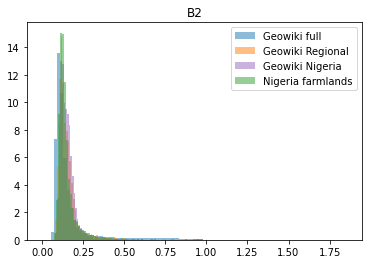

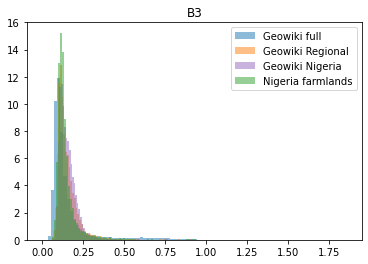

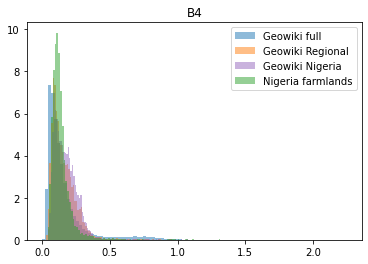

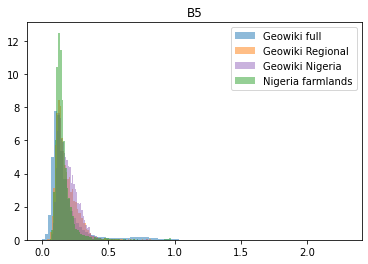

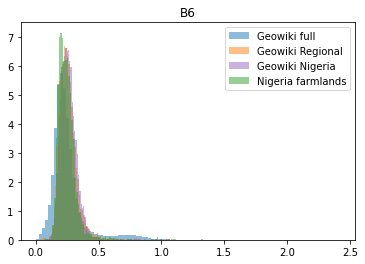

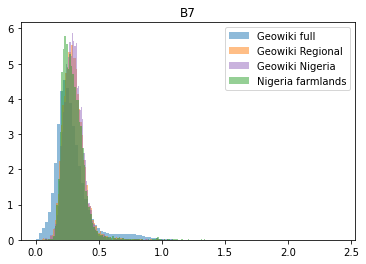

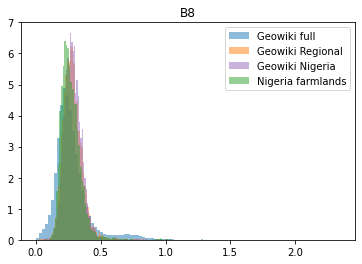

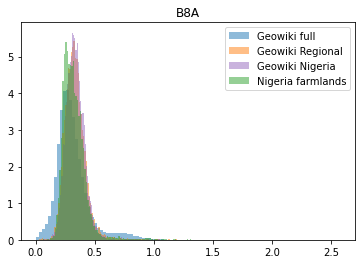

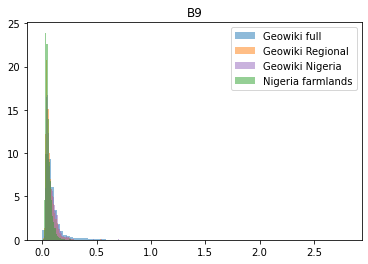

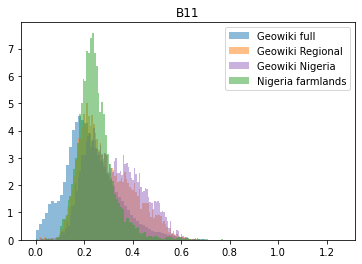

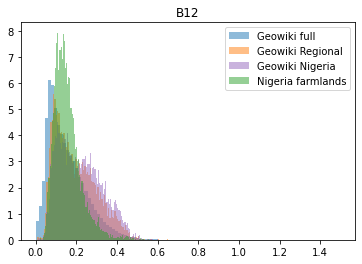

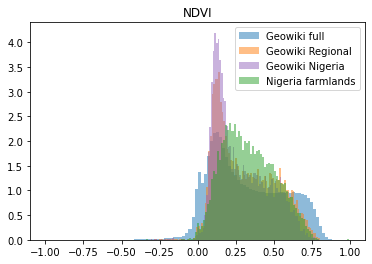

In [36]:
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green']
for band in bands:
    #cropland = np.concatenate(gdf[gdf['label'] >= 0.5][band].to_list())
    #non_cropland = np.concatenate(gdf[gdf['label'] < 0.5][band].to_list())
    full_geowiki_array = np.concatenate(gdf[band].to_list())
    regional_geowiki_arrary = np.concatenate(regional[band].to_list())
    nigeria_geowiki_array = np.concatenate(nigeria[band].to_list())
    nigeria_farmlands_array = np.concatenate(df_nigeria[band].to_list())
    #s, p = stats.normaltest(np.log(all))
    #print(s, p)
    #plt.hist(cropland, density=True, bins=100, label='cropland')
    #plt.hist(non_cropland, density=True, bins=100, label='non_cropland')
    plt.hist(full_geowiki_array, density=True, bins=100, color=colors[0], alpha=0.5, label='Geowiki full')
    plt.hist(regional_geowiki_arrary, density=True, bins=100, color=colors[1], alpha=0.5, label='Geowiki Regional')
    plt.hist(nigeria_geowiki_array, density=True, bins=100, color=colors[2], alpha=0.5, label='Geowiki Nigeria')
    plt.hist(nigeria_farmlands_array, density=True, bins=100, color=colors[3], alpha=0.5, label='Nigeria farmlands')
    plt.legend()
    plt.title(band)
    plt.show()

In [22]:
full_geowiki_array = np.concatenate(gdf[band].to_list())
regional_geowiki_arrary = np.concatenate(regional[band].to_list())
nigeria_geowiki_array = np.concatenate(nigeria[band].to_list())
nigeria_farmlands_array = np.concatenate(df_nigeria[band].to_list())

In [23]:
str(countries)

"['Nigeria', 'Cameroon', 'Benin', 'Togo', 'Ghana']"

In [33]:
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green']
labels = ['Geowiki full', f'Geowiki regional {str(countries)}', 'Geowiki Nigeria', 'Nigeria farmlands (test set)']

Text(0.5, 0.98, 'Data distribution per band/feature')

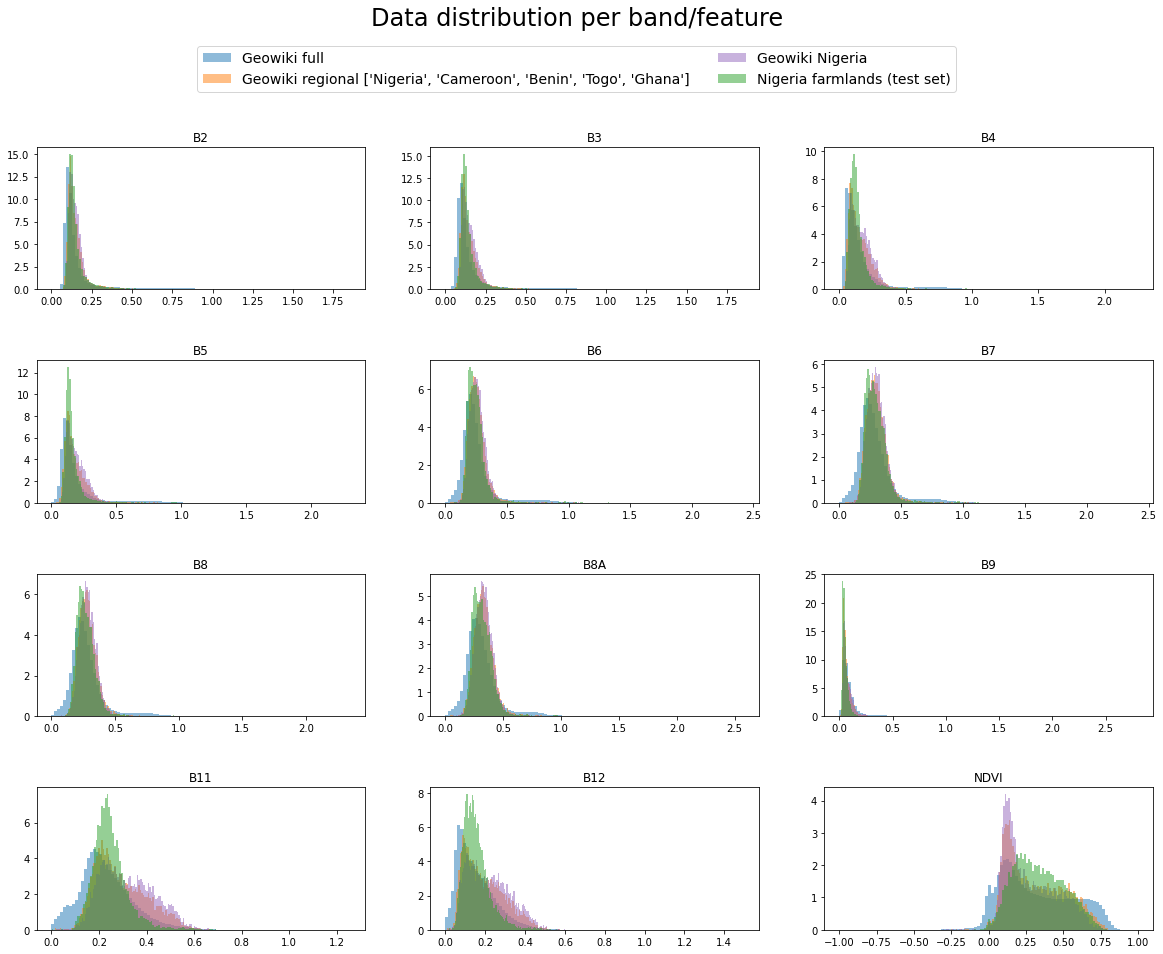

In [34]:
num_plots = len(bands)
n_cols = 4
n_rows = num_plots // n_cols if num_plots % n_cols == 0 else num_plots // n_cols + 1

fig, axs = plt.subplots(n_cols, n_rows, figsize=(20, 15))
x_axis = np.arange(-0.5, 1, 0.01)

for band_idx, band in enumerate(bands):
    full_geowiki_array = np.concatenate(gdf[band].to_list())
    regional_geowiki_arrary = np.concatenate(regional[band].to_list())
    nigeria_geowiki_array = np.concatenate(nigeria[band].to_list())
    nigeria_farmlands_array = np.concatenate(df_nigeria[band].to_list())
    arrays = [full_geowiki_array, regional_geowiki_arrary, nigeria_geowiki_array, nigeria_farmlands_array]
    
    ax = plt.subplot(n_cols, n_rows, band_idx + 1)
    
    for i, array in enumerate(arrays):
        ax.hist(array, density=True, bins=100, color=colors[i], alpha=0.5)
    
    # Subplot level
    ax.set_title(f'{bands[band_idx]}')
    #plt.legend()

# Figure level    
fig.legend(labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=14, ncol=2)
plt.subplots_adjust(top=0.85, hspace=0.5)
fig.suptitle(f'Data distribution per band/feature', fontsize=24)

- **Seems that distributions are lognormal**

TODOS:
- Plot histogram plus density lines (per band like in notebook 4)
- Clean, don't repeat code